__Tutorial 2: Logistic Regression - Classifiers and Regularizers__
***
In this tutorial, we consider the Bernoulli GLM (a.k.a. Logistic Regression). Logistic Regression makes use of the sigmoid curve, so it is appropriate for binary classification tasks. For the Bernoulli GLM, the probability mass function is:
$$
p(y_i|p_i) = p_i^{y_i} (1 - p_i)^{1 - y_i}, p_i = \sigma(\boldsymbol{\theta}^T \boldsymbol{x}_i)
$$
and the sigmoid curve is defined as:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
Finally, the probability surface, $-\ln \mathcal{L}(\boldsymbol{\theta} | \boldsymbol{X}, \boldsymbol{y})$, for Bernoulli GLM is defined (in component form) as:
$$
-\sum_{i=1}^N [y_i \ln(\sigma(\boldsymbol{\theta}^T \boldsymbol{x}_i)) + (1 - y_i)\ln(1 - \sigma(\boldsymbol{\theta}^T \boldsymbol{x}_i))]
$$
This probability surfance, like in the Linear-Gaussian and Poisson cases, is also convex, and can take advantage of gradient descent for minimization in the abscence of an analytical solution. (Note: the functional form of the probability surface in Logistic Regression mirrors the loss surface of feedforward neural networks that implement cross-entropy cost).

Below, we use a Bernoulli GLM as a decoding model (predicting behavior from neural response data) to predict one of two choices (binary classification) in an experiment of mice. Mice had the task of turning a wheel to indicate whether they perceived a Gabor stimulus to the left, to the right, or not at all. Neuropixel probes measured spikes across the cortex. Using the neural response data, we will fit the model to see if we can decode when the mouse perceived the stimulus to the left or to the right.

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Figure settings
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Plotting Functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

# Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

Below we explore the shape of the data. Our neural response data is a matrix containing the spiking rate of each measured neuron, and the behavior is a vector of $0$'s and $1$'s indicating left and right for the visual stimulus (the mouse's choice).

In [14]:
# store the Steinmetz dataset
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

# NOTICE: for decoding tasks, the neural response is the explanatory variable (design matrix X), 
# while y corresponds to something in the experiment

y = data["choices"] # vector of 0s and 1s indicating the animal's behavioral response with length n_trials=276
X = data["spikes"] # an array of normalized spike rates with shape (n_trials, n_neurons)

spikes (276, 691)
choices (276,)


We can use scikit-learn to build and fit our Logistic Regression model, where the _LogisticRegression_ class implements the math described above.

In [15]:
# Define the model (using scikit-learn)
log_reg = LogisticRegression(penalty="none")

# Fit it to data
log_reg.fit(X, y)

# Use learned weights to classify new data
y_pred = log_reg.predict(X)

In the case of binary classification, we can quantify the accuracy of the model as the mean number of predictions matched the test data. Using $k$-fold cross validation $(k=8)$, we see that there is a large difference between accuracy on the training set and test set ($100$% and $86.59$%), which indicates that the model is overfitting to the training data.
- When a model has much more features than samples, overfitting is almost guaranteed (as a toy example, imagine fitting a line in R^2 to a single datapoint: there are an infinite number of choices for the slope)
- Neural data often has this quality: e.g., more neurons than independent trials

Accuracy on the training data: 100.00%


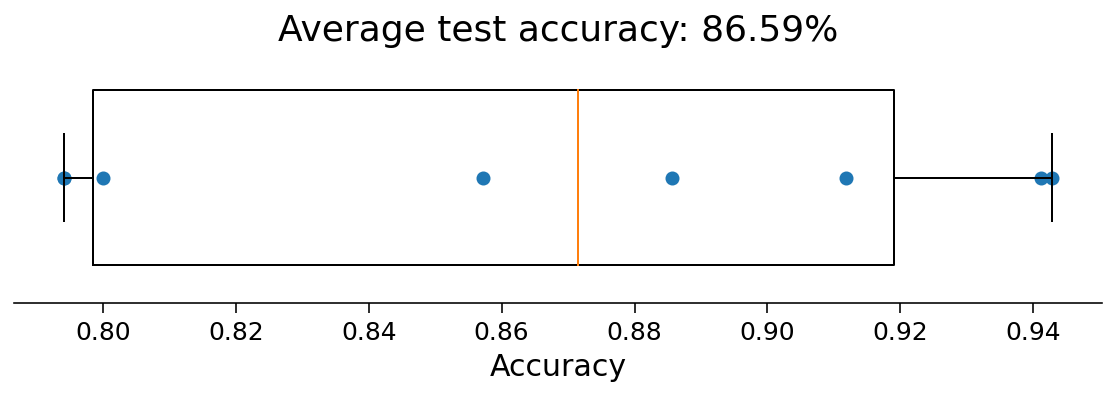

In [16]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(X)

  accuracy = (y == y_pred).mean()

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

# Compute cross-validated accuracy
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8)  # k=8 cross validation

# plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

To reduce overfitting, we introduce two forms of regularization: L2 and L1 regularization. With L2 regularization, we augment our objective function (negative log likelihood) with what is referred to as a "ridge" penalty:
$$
-\ln \mathcal{L}'(\boldsymbol{\theta} | \boldsymbol{X}, \boldsymbol{y}) = -\ln \mathcal{L}(\boldsymbol{\theta} | \boldsymbol{X}, \boldsymbol{y}) + \frac{\beta}{2} \sum_{i} \theta_i^2
$$
Where $\beta$ is a _hyperparameter_ of the model determining the strength of the regularization. By adding the square of each of the weights to the objective function, each of the weights decreases at a rate proportional to its current magnitude until either the objective function is minimized or the weight has reached zero (think: derivative of a squared term). Because of this, L2 regularization generally results in many very small non-zero weights (the derivative of the squared term approaches zero near its minimum). In other words, the model is penalized for large weights, but the parameter space is not sparse.

Heuristically, this preference for small weights can be though of as reducing the complexity of the model, like when polynomial fits of different orders were compared before. The smaller the weights, the less complex the model is, and the less likely the model is to overfit to the data.

Using scikit-learn, the strength of regularization is determined by $C = \frac{1}{\beta}$, the inverse regularization. Below we visualize the effects of regularization for various choices of $C$.

In [17]:
# Precompute the models so the widget is responsive
log_C_steps = 1, 11, 1
penalized_models = {}
for log_C in np.arange(*log_C_steps, dtype=int):
  m = LogisticRegression("l2", C=10 ** log_C, max_iter=5000)
  penalized_models[log_C] = m.fit(X, y)

@widgets.interact
def plot_observed(log_C = widgets.FloatSlider(value=1, min=1, max=10, step=1)):
  models = {
    "No regularization": log_reg,
    f"$L_2$ (C = $10^{log_C}$)": penalized_models[log_C]
  }
  plot_weights(models)

interactive(children=(FloatSlider(value=1.0, description='log_C', max=10.0, min=1.0, step=1.0), Output()), _do…

Another method of regularization is L1 (Lasso) regularization. In this case, the objective function looks like:
$$
-\ln \mathcal{L}'(\boldsymbol{\theta} | \boldsymbol{X}, \boldsymbol{y}) = -\ln \mathcal{L}(\boldsymbol{\theta} | \boldsymbol{X}, \boldsymbol{y}) + \frac{\beta}{2} \sum_{i} |\theta_i|
$$
In this case, the derivative of the absolute value term is a constant. Thus, as the negative log likelihood is minimized, all of the weights decrease at a constant rate towards zero. The result is that only the salient features (largest weights) of the model are left non-zero, and the parameter space is very sparse. The reason why L1 regularization reduces overfitting is clear: only the features corresponding to the non-zero weights are considered by the model.

Below we visualize L1 versus L2 regularization with the same regularization strength to emphasize the sparsity of the parameter space when using L1 regularization.

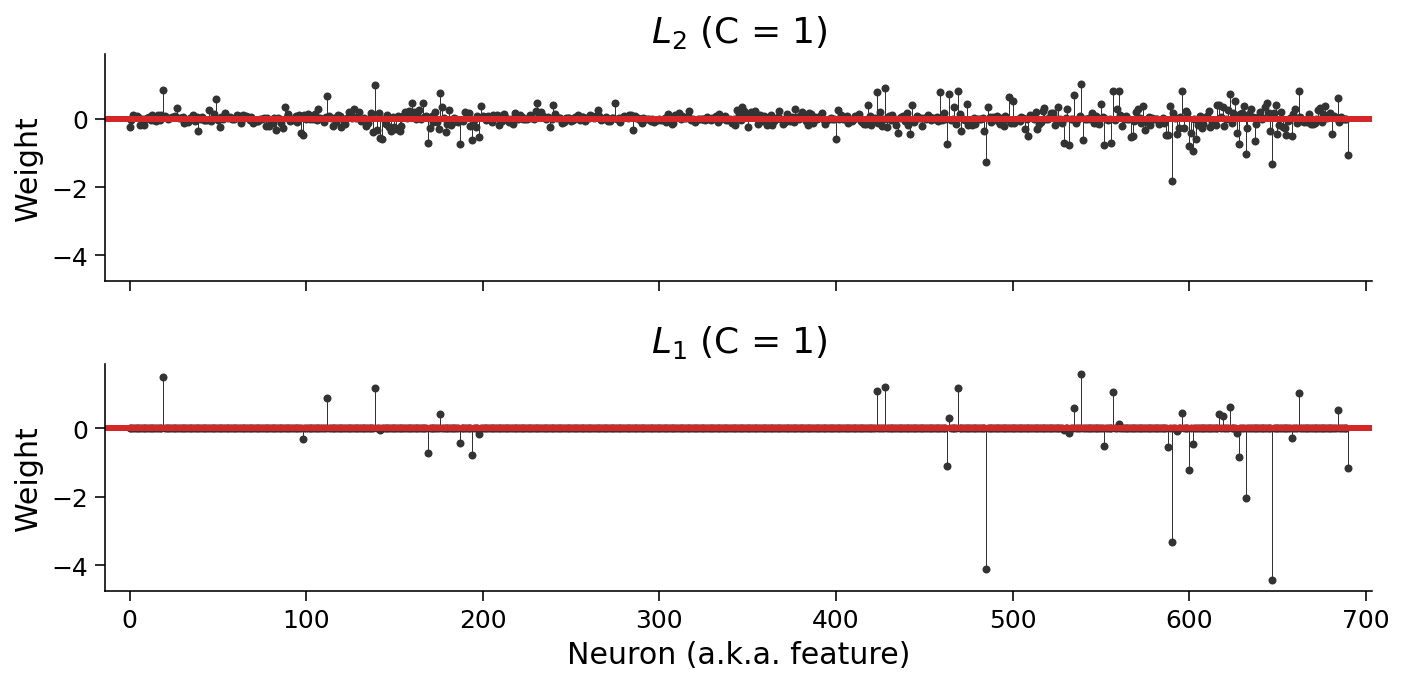

In [21]:
# Compare no regularization to L1 (Lasso) Regularization

log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

We then implement a function to count the number of non-zero weights for discrete choice of the hyperparamter $C$.

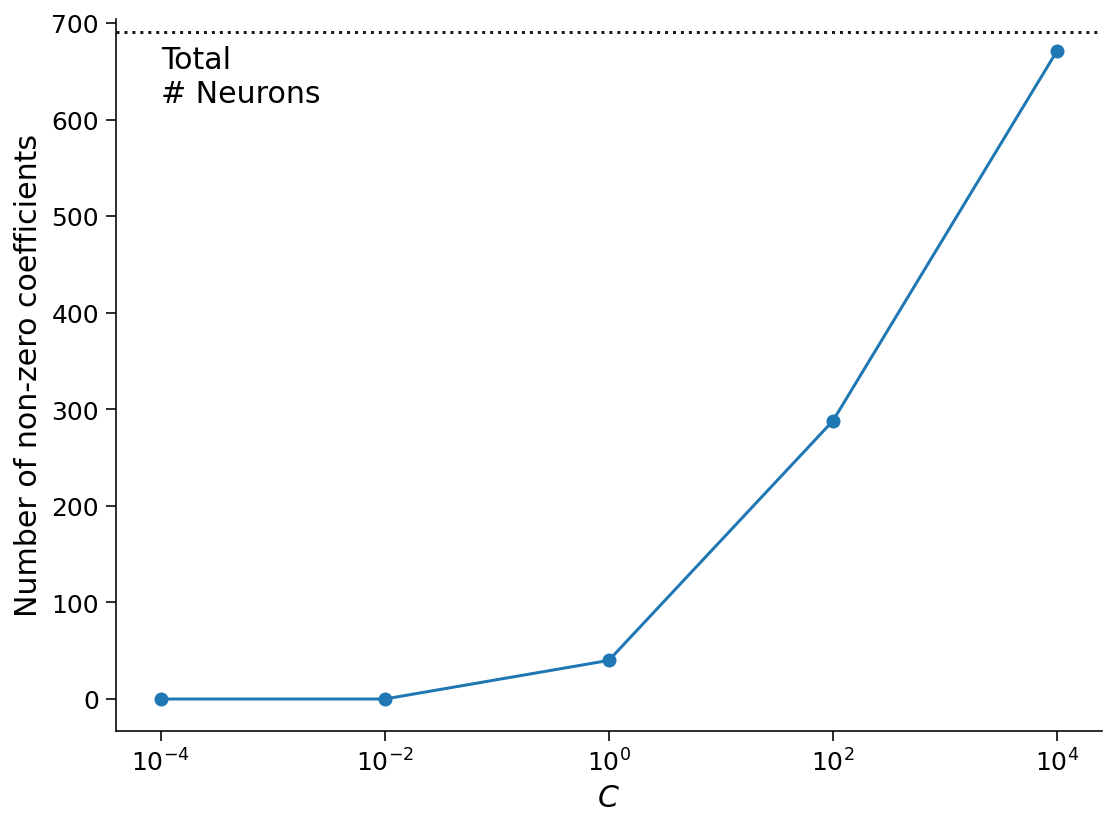

In [19]:
# Explore the effect of L1 regularization on parameter sparsity

def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values

  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero

  """

  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X,y)

    # Get the coefs of the fit model (in sklearn, we can do this using model.coef_)
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.sum(coefs != 0)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

# Count non zero coefficients
non_zero_l1 = count_non_zero_coefs(X, y, C_values)

# Visualize
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X.shape[1])

Lastly, we verify the choice of the hyperparameter $C$ using $k$-fold cross validation $(k=8)$. We see that classification accuracy on the test set is maximized for $C=1$

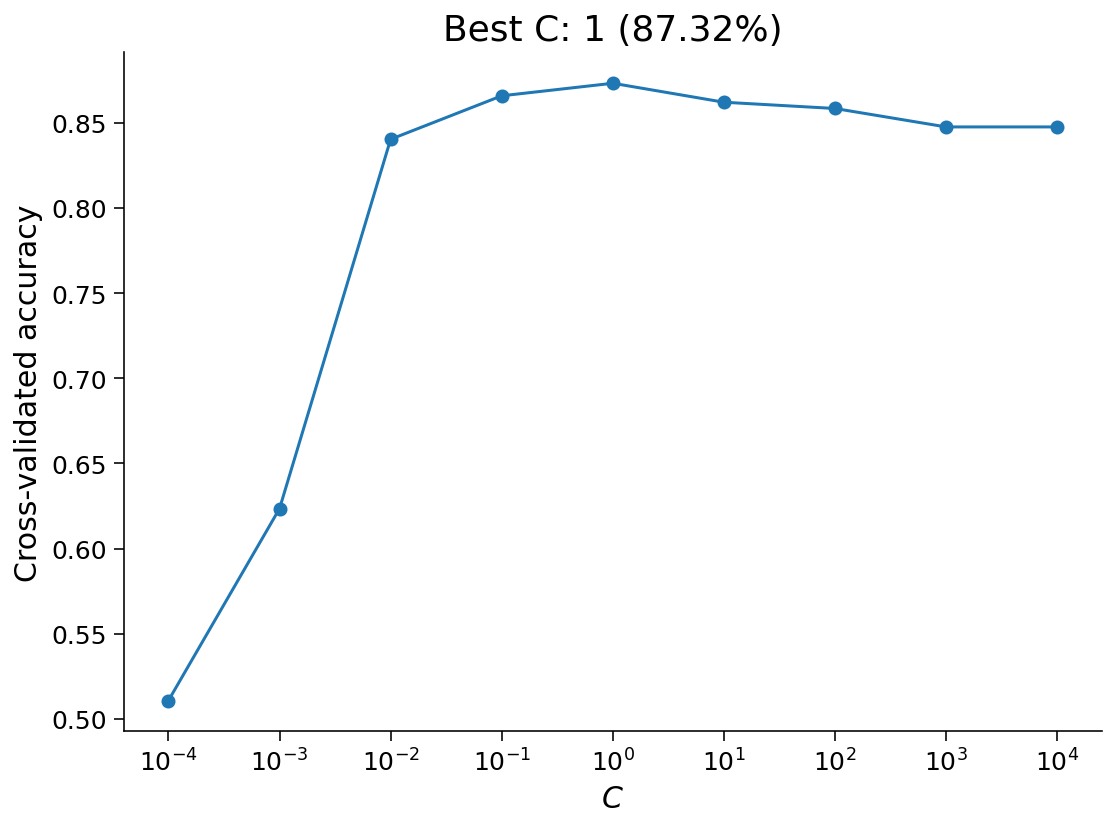

In [20]:
# Use cross-validation to select optimal hyperparameter for L2 regularization

def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

  Returns:
    accuracies (1D array): CV accuracy with each value of C

  """

  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=8)  # k=8 cross validation

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies)